### 1a) Import Libraries

In [90]:
import networkx as nx
#pip3 install python-louvain
from collections import Counter
from community import community_louvain
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import gzip
import unicodedata
import pprint
from itertools import chain
from networkx.algorithms.community.centrality import girvan_newman

### 1b) Import Dataset (User ID, Tweet, Mention User ID)

In [46]:
#Building features from raw data
with gzip.open('gamergate.json.gz','rb') as f:
    count = 0
    for line in f:
        status = json.loads(line)
        mention = status['entities']['user_mentions']
        li_mention = []
        for m in mention:
            li_mention.append(str(m['id_str']))
        mentions = ','.join(e for e in li_mention)
        raw_series = pd.Series({'name':status['user']['id_str'],'text':status['text'],
                               '@User_Mentions':mentions})
        raw_features = pd.DataFrame([raw_series],index =[count])
        if count == 0:
            raw_features.to_csv('gamergate.csv')
        if count > 0:
            raw_features.to_csv('gamergate.csv', mode='a', header=False)
        count += 1
gg_data = pd.read_csv('gamergate.csv')
gg_data = gg_data.drop(['Unnamed: 0'], axis=1)
print("Number of rows: %d"% len(gg_data))


Number of rows: 104932


### Map User ID with it's Mention User IDs

In [91]:
gg_data = pd.read_csv('gamergate.csv')
gg_data['text'] = gg_data['text'].str.strip('"')
dat = gg_data[~gg_data['text'].astype(str).str.startswith('RT @')] 
dat = dat[~dat['text'].astype(str).str.startswith('rt @')] 
# Refer https://www.wikihow.com/Retweet
#Sometimes people type "RT" at the beginning of a Tweet to indicate that they are re-posting someone else's content
#Removed Retweets
dat.head()

,Unnamed: 0,name,text,@User_Mentions
1,1,251045973,@canar Mercedes-Benz didn't even revert. Just ...,2858053259
3,3,2847688135,.@daddy_warpig's stream is live @ http://t.co/...,65974890
6,6,36790442,I added a video to a @YouTube playlist http://...,10228272
10,10,171848975,hey if Kotaku is tired of #GamerGate why don't...,NaN
11,11,49724410,@RogueStarGamez @SerialExpansion @whisthiseven...,"2275538935,2826306403,16589206"


In [92]:
dat = dat[['name','text','@User_Mentions']].dropna()
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(',')))
# calculate lengths of splits
lens = dat['@User_Mentions'].str.split(',').map(len)
result = pd.DataFrame({'name': np.repeat(dat['name'], lens),'@User_Mentions': chainer(dat['@User_Mentions'])})

In [93]:
result.head()  # ID of user and Mention ID from mention field from tweet object 
# Refer : https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/entities-object.html
# Removed non mentioned tweets
# Removed Retweets

,name,@User_Mentions
1,251045973,2858053259
3,2847688135,65974890
6,36790442,10228272
11,49724410,2275538935
11,49724410,2826306403


### Export to Text File

In [94]:
result.to_csv(r'C:\Users\Ikshita\Documents\spark-2.3.1-bin-hadoop2.7\bin\DSSS\SocialData.txt', header=None, index=None, sep='\t')

### Social Network Analysis

### 1c) Mention Graph

In [95]:
G=nx.read_edgelist('SocialData.txt')

### 1d)  Degree centrality, Node Clustering Coefficient, Eigenvector Centrality, PageRank.

###### Clustering Coefficient

In [96]:
clustering_coef=nx.clustering(G)  #clustering of a node u is the fraction of possible 'triangles' through that node that exist!
print('Clustering Coefficient:',clustering_coef)

Clustering Coefficient: {'251045973': 0.042105263157894736, '2858053259': 0.1, '2847688135': 0, '65974890': 0.05555555555555555, '36790442': 0, '10228272': 0.0027226137091607944, '49724410': 0.4, '2275538935': 0.01580020387359837, '2826306403': 0.0370872908186341, '16589206': 0.013071895424836602, '87329702': 0.1, '2439015974': 0.058823529411764705, '171848975': 0.17857142857142858, '124578566': 0.12121212121212122, '2529074661': 1.0, '342849123': 0, '2802164402': 0.034274193548387094, '1242190802': 0.13636363636363635, '262538589': 0.07692307692307693, '535688170': 0, '2213370912': 0.005042016806722689, '2756873076': 0.06060606060606061, '334921581': 0.019710485550985524, '1043436650': 0.06666666666666667, '2797386391': 0.030721966205837174, '424806929': 0.006060606060606061, '3214547675': 0.013313609467455622, '2472399354': 0.005343704546891798, '562393058': 0.0020161290322580645, '102215904': 0.09090909090909091, '159708757': 0.06984126984126984, '583756751': 0.03346938775510204, '2

###### Degree Centrality

In [97]:
degree_cen = nx.degree_centrality(G)
print('Degree centrality:', degree_cen,'\n')

Degree centrality: {'251045973': 0.0022901637467078895, '2858053259': 0.0005725409366769724, '2847688135': 0.00034352456200618345, '65974890': 0.005152868430092752, '36790442': 0.00011450818733539448, '10228272': 0.025649833963128362, '49724410': 0.0005725409366769724, '2275538935': 0.012481392419557999, '2826306403': 0.00767204855147143, '16589206': 0.0020611473720371005, '87329702': 0.0005725409366769724, '2439015974': 0.0020611473720371005, '171848975': 0.0011450818733539448, '124578566': 0.0013740982480247338, '2529074661': 0.00022901637467078896, '342849123': 0.00022901637467078896, '2802164402': 0.0036642619947326233, '1242190802': 0.0013740982480247338, '262538589': 0.0016031146226955226, '535688170': 0.00011450818733539448, '2213370912': 0.004007786556738807, '2756873076': 0.0037787701820680177, '334921581': 0.02221458834306653, '1043436650': 0.0017176228100309172, '2797386391': 0.007214015802129852, '424806929': 0.007786556738806825, '3214547675': 0.019351883659681667, '247239

###### Eigenvector Centrality

In [98]:
eigen_cen = nx.eigenvector_centrality(G)
print('Eigenvector centrality:', eigen_cen, '\n')

Eigenvector centrality: {'251045973': 0.01676233014873484, '2858053259': 0.005113090973462349, '2847688135': 0.0009326679417989283, '65974890': 0.0356789395327695, '36790442': 0.0016355339991984362, '10228272': 0.06566917391716404, '49724410': 0.005790024179411502, '2275538935': 0.06917070919385467, '2826306403': 0.0502968066814025, '16589206': 0.0042355864806759074, '87329702': 0.0075368678831557135, '2439015974': 0.017865110548365162, '171848975': 0.01424075501655876, '124578566': 0.00738157729246718, '2529074661': 0.0018441583506026613, '342849123': 0.00047410446690489803, '2802164402': 0.019060639655493393, '1242190802': 0.015497021798632977, '262538589': 0.017089842926323734, '535688170': 0.00042540533866707226, '2213370912': 0.01607097199628819, '2756873076': 0.04155582131147144, '334921581': 0.12971655257487288, '1043436650': 0.017024481744306267, '2797386391': 0.04488971646651004, '424806929': 0.025634274411594753, '3214547675': 0.10720171292550228, '2472399354': 0.122251226409

###### Page Rank

In [99]:
Page_Rank = nx.pagerank(G, alpha=0.9)
print('Page Rank:', Page_Rank)

Page Rank: {'251045973': 0.00034795285418527704, '2858053259': 9.2506379723541e-05, '2847688135': 8.223743015740066e-05, '65974890': 0.0007938423243366369, '36790442': 3.0544376023287436e-05, '10228272': 0.0047713890693604445, '49724410': 0.00010059938943430405, '2275538935': 0.0018949867236467903, '2826306403': 0.001190855032307539, '16589206': 0.00039331166134796926, '87329702': 9.760476438993001e-05, '2439015974': 0.0003479770929665557, '171848975': 0.00015189088132176227, '124578566': 0.000244538160843736, '2529074661': 4.682576978452032e-05, '342849123': 4.703514423400695e-05, '2802164402': 0.0006294009378814119, '1242190802': 0.00022166404330451955, '262538589': 0.0002457888719260304, '535688170': 2.7277483250481626e-05, '2213370912': 0.0006573689868793264, '2756873076': 0.0006184040466563277, '334921581': 0.0033822057742635874, '1043436650': 0.00025930796951648783, '2797386391': 0.0012283404739380026, '424806929': 0.0012436056724501726, '3214547675': 0.0029593180273057534, '2472

-------------------------------------------------------------------------------------------------------------------
###   1e) Node Degree Distribution, Number of Connected Components, Network Density, Number of Nodes and Edges.


In [100]:
print(nx.info(G)) 

Name: 
Type: Graph
Number of nodes: 8734
Number of edges: 21250
Average degree:   4.8660



#### Number of connected components

In [101]:
print('Number of Connected Components', nx.number_connected_components(G))

Number of Connected Components 425



#### Network Density

In [102]:
print('Network Density',nx.density(G))

Network Density 0.0005572015069560643


#### Node Degree Distribution

In [103]:
print('Degree Distribution', G.degree())

Degree Distribution [('251045973', 20), ('2858053259', 5), ('2847688135', 3), ('65974890', 45), ('36790442', 1), ('10228272', 224), ('49724410', 5), ('2275538935', 109), ('2826306403', 67), ('16589206', 18), ('87329702', 5), ('2439015974', 18), ('171848975', 10), ('124578566', 12), ('2529074661', 2), ('342849123', 2), ('2802164402', 32), ('1242190802', 12), ('262538589', 14), ('535688170', 1), ('2213370912', 35), ('2756873076', 33), ('334921581', 194), ('1043436650', 15), ('2797386391', 63), ('424806929', 68), ('3214547675', 169), ('2472399354', 252), ('562393058', 32), ('102215904', 11), ('159708757', 36), ('583756751', 50), ('2760592636', 72), ('365752442', 52), ('135385733', 8), ('54502344', 21), ('2837175356', 126), ('21138801', 4), ('2375850864', 27), ('2815279566', 164), ('37093993', 81), ('14940187', 6), ('39363', 1), ('2835323565', 14), ('14672744', 3), ('133005951', 1), ('12376612', 4), ('10286932', 1), ('1543337340', 59), ('8936082', 395), ('2467791', 22), ('21540556', 33), (

### 1f) Calculate the network community structure with an algorithm of your choice, appropriate to the size of the network. 

Best Partition (Uses Louvain algorithm)

Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices
This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.
Optimizing this value theoretically results in the best possible grouping of the nodes of a given network, however going through all possible iterations of the nodes into groups is impractical so heuristic algorithms are used. In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated. 

In [104]:
part = community_louvain.best_partition(G)
print(part)

{'251045973': 0, '2858053259': 0, '2847688135': 1, '65974890': 1, '36790442': 2, '10228272': 2, '49724410': 3, '2275538935': 4, '2826306403': 4, '16589206': 5, '87329702': 6, '2439015974': 6, '171848975': 2, '124578566': 7, '2529074661': 7, '342849123': 8, '2802164402': 7, '1242190802': 7, '262538589': 6, '535688170': 6, '2213370912': 2, '2756873076': 6, '334921581': 0, '1043436650': 0, '2797386391': 0, '424806929': 2, '3214547675': 7, '2472399354': 2, '562393058': 9, '102215904': 0, '159708757': 0, '583756751': 0, '2760592636': 3, '365752442': 7, '135385733': 2, '54502344': 6, '2837175356': 10, '21138801': 10, '2375850864': 10, '2815279566': 3, '37093993': 11, '14940187': 12, '39363': 11, '2835323565': 4, '14672744': 13, '133005951': 13, '12376612': 13, '10286932': 13, '1543337340': 14, '8936082': 15, '2467791': 16, '21540556': 16, '2333078484': 17, '1870274954': 17, '857720059': 18, '430338983': 18, '16811031': 4, '41085012': 19, '268382812': 4, '235216483': 0, '16710197': 0, '129675

In [105]:
size = len(set(part.values()))
print('No. of Communities', size)

No. of Communities 452



### 1g) Node degree distribution, Community-Size distribution

##### Plot Node Degree Distribution

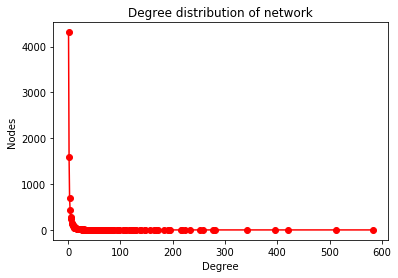

In [106]:
dd_dic = Counter(dict(nx.degree(G)).values())
lists = sorted(dd_dic.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y,'ro-')
plt.xlabel('Degree')
plt.ylabel('Nodes')
plt.title('Degree distribution of network')
plt.show()

-------------------------------------------------------------------------------------------------------------------
#### Plot Degree Distribution (LogLog Plot)

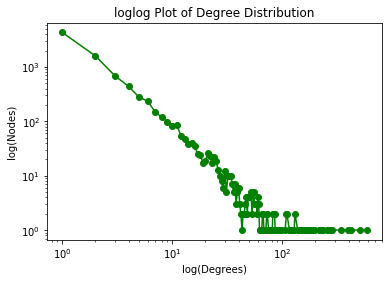

In [107]:
plt.loglog(x, y,'go-')
plt.xlabel('log(Degrees)')
plt.ylabel('log(Nodes)')
plt.title('loglog Plot of Degree Distribution')
plt.show()

-------------------------------------------------------------------------------------------------------------------
#### Plot Social Graph

Name: 
Type: Graph
Number of nodes: 8734
Number of edges: 21250
Average degree:   4.8660


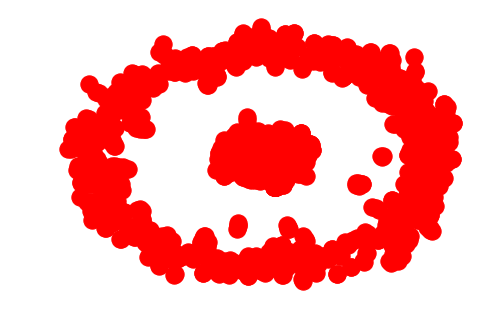

In [108]:
print(nx.info(G))
nx.draw(G)
plt.show()


-------------------------------------------------------------------------------------------------------------------
#### Plot Circular Social Graph

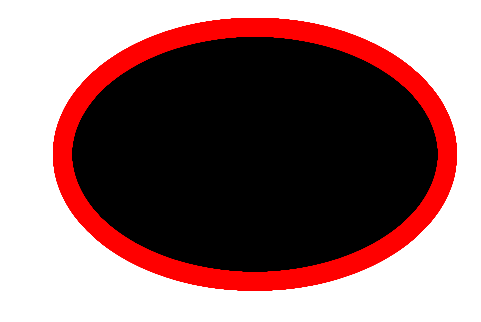

In [109]:
nx.draw_circular(G)
plt.show()

#### Plot Community Size Distribution

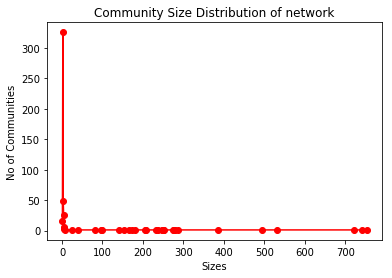

In [110]:
'''
Example:
Community 1 : 2 nodes
Community 2 : 1 node
Community 3 : 2 nodes

Size : Communities
2: Community 1,3
1 Community 2

i.e.

Size : Number of Communities
2 : 2
1: 1

'''



dic_size = Counter(part.values())
plot_size = Counter(dic_size.values())
lists_size = sorted(plot_size.items()) #  no of communities in each size
x_size, y_size = zip(*lists_size) # unpack a list of pairs into two tuples
plt.plot(x_size, y_size,'ro-')
plt.xlabel('Sizes')
plt.ylabel('No of Communities')
plt.title('Community Size Distribution of network')
plt.show()


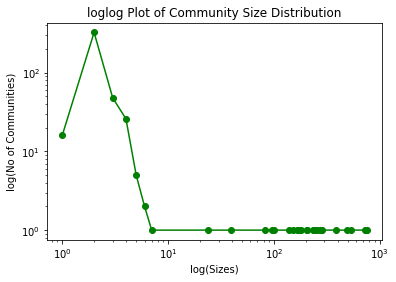

In [111]:
plt.loglog(x_size, y_size,'go-')
plt.xlabel('log(Sizes)')
plt.ylabel('log(No of Communities)')
plt.title('loglog Plot of Community Size Distribution')
plt.show()

#### 2)Optional (for bonus points): Plot the network using colors representing different communities, and sizes representing a centrality measure of your choice. Use an appropriate network layout. If the network is too large to be plotted in an insightful way, demonstrate your ability to identify interesting subnetworks and plot them separately to gather insights.

#### 1st Method: Centrality Measure - Betweenness

In [112]:
between_cen = nx.betweenness_centrality(G)
print('Betweenness centrality:', between_cen, '\n')

Betweenness centrality: {'251045973': 0.0006201070618678262, '2858053259': 1.1325682406297754e-05, '2847688135': 0.00020525326505105003, '65974890': 0.0024383611335741483, '36790442': 0.0, '10228272': 0.02695603744728191, '49724410': 5.228193413827243e-05, '2275538935': 0.007237997227773519, '2826306403': 0.004245542603725344, '16589206': 0.0013705339638066336, '87329702': 6.058017114007907e-05, '2439015974': 0.0011981026827496467, '171848975': 2.3060331919505464e-05, '124578566': 0.0005230513803920941, '2529074661': 0.0, '342849123': 8.983151587741274e-07, '2802164402': 0.0027554170626639656, '1242190802': 0.00018801470697144562, '262538589': 0.0004084910008126922, '535688170': 0.0, '2213370912': 0.0021884009020296884, '2756873076': 0.002562150338322779, '334921581': 0.018968373004342474, '1043436650': 0.0002779861132034785, '2797386391': 0.0071694720704567, '424806929': 0.0036540180009503576, '3214547675': 0.012840009320497099, '2472399354': 0.02661537032867603, '562393058': 0.001214

#### Louvian Method : Best Partition 

In [113]:
part = community_louvain.best_partition(G)
size = len(set(part.values()))
print('No. of Communities', size)

No. of Communities 452


#### Plot Communities

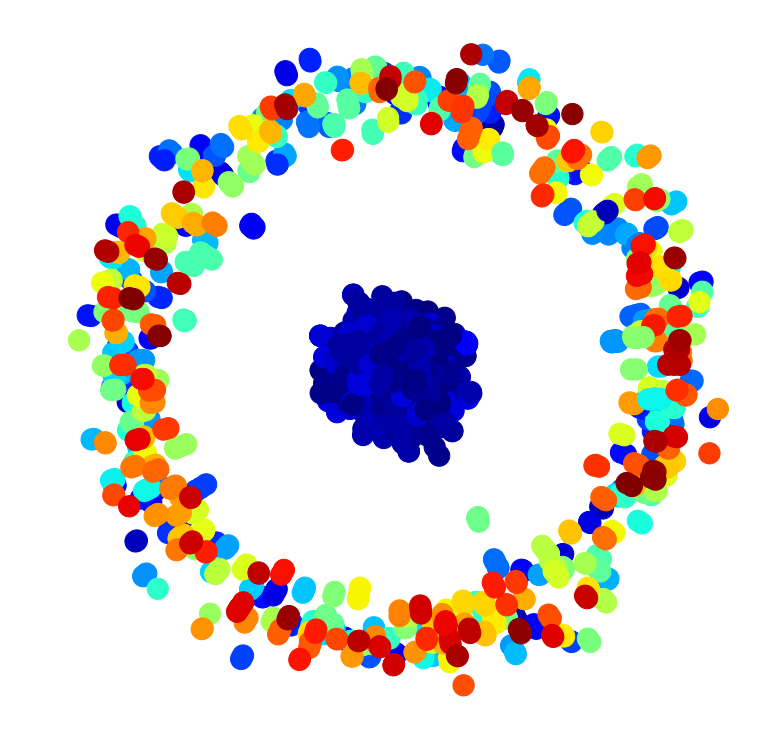

In [114]:
node_sizes = []  #initialize a list to keep track of node sizes
for n in list(G.nodes):  #for each node
    node_sizes.append(size+(between_cen[n]*1000))  #make it's node size = 1000 times it's betweeness centrality + no comms

values = [part.get(node) for node in G.nodes()]

nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color=values, node_size=node_sizes, with_labels=False)
plt.gcf().set_size_inches(10, 10)
plt.show()

In [115]:
print('modularity:', community_louvain.modularity(part,G))

modularity: 0.4687654200692139


Insight : There are 452 communities in Mention (@) graph. There are a lot of instance where people have mentioned a common tweet user. 